# Sarcasmo Clasiffier

In [225]:
import os 
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.functional as taF
from torch.utils.data import Dataset, random_split, DataLoader
import torchaudio

import pandas as pd
import numpy as np

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [145]:
class SarcasmDataset(Dataset):
    
    def __init__(self, file_path: str):
        self.file_path=file_path 
        
        walker = sorted(str(p) for p in Path(self.file_path).glob(f'*/*'))
        self.walker = list(walker)
        
    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        fileid = self.walker[n]
        label= self.walker[n].split('/')[-2]
        
        relpath = os.path.relpath(fileid, self.file_path)
        label, filename = os.path.split(relpath)
        waveform, sample_rate = torchaudio.load(fileid)
        waveform_mono = torch.mean(waveform, dim=0, keepdim=True)
        seg_duration = len(waveform_mono[0])/sample_rate #expresed in seconds
        
        return waveform_mono, sample_rate, label, seg_duration, fileid
    
    def __len__(self) -> int:
        return len(self.walker)

In [184]:
data=SarcasmDataset('../Audios/mp3')

## Data quality

In [147]:
d = {"sample_rate":[], "label":[], "seg_duration":[], "fileid":[]}

for i in range(len(data)):
    datos = data[i]
    d["sample_rate"].append(datos[1])
    d["label"].append(datos[2])
    d["seg_duration"].append(datos[3])
    d["fileid"].append(datos[4])

In [148]:
table_data = pd.DataFrame.from_dict(d)

In [149]:
table_data.head

<bound method NDFrame.head of      sample_rate     label  seg_duration                               fileid
0          44100    Normal      6.347755     ../Audios/mp3/Normal/Audio_1.mp3
1          44100    Normal     12.747755    ../Audios/mp3/Normal/Audio_10.mp3
2          48000    Normal     15.840000   ../Audios/mp3/Normal/Audio_100.mp3
3          48000    Normal      9.408000   ../Audios/mp3/Normal/Audio_101.mp3
4          44100    Normal      5.120000    ../Audios/mp3/Normal/Audio_11.mp3
..           ...       ...           ...                                  ...
202        48000  Sarcasmo      5.693500  ../Audios/mp3/Sarcasmo/Audio_95.mp3
203        48000  Sarcasmo      2.957833  ../Audios/mp3/Sarcasmo/Audio_96.mp3
204        48000  Sarcasmo     21.057833  ../Audios/mp3/Sarcasmo/Audio_97.mp3
205        48000  Sarcasmo      5.777833  ../Audios/mp3/Sarcasmo/Audio_98.mp3
206        48000  Sarcasmo      3.673500  ../Audios/mp3/Sarcasmo/Audio_99.mp3

[207 rows x 4 columns]>

In [150]:
table_data.describe()

,sample_rate,seg_duration
count,207.000000,207.000000
mean,46869.565217,5.487632
std,1773.699798,3.816620
min,44100.000000,1.149388
25%,44100.000000,3.169325
50%,48000.000000,4.557833
75%,48000.000000,6.347755
max,48000.000000,31.164082


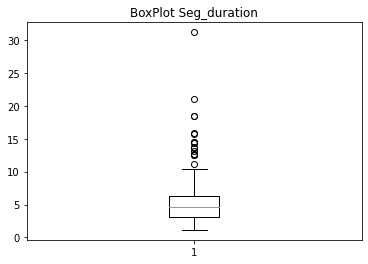

In [151]:
import numpy as np
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('BoxPlot Seg_duration')
ax1.boxplot(table_data["seg_duration"])
plt.show()

In [152]:
table_data[table_data["seg_duration"]>30]

,sample_rate,label,seg_duration,fileid
175,44100,Sarcasmo,31.164082,../Audios/mp3/Sarcasmo/Audio_70.mp3


In [153]:
display(Audio(table_data[table_data["seg_duration"]>30]["fileid"].values[0]))

<font color='red'>**We should delete this sample**</font>

## Normalization

In [172]:
# same sample rate for all audios
resample_rate = 44100

resampled_waveform = taF.resample(data[0][0], data[0][1], resample_rate, rolloff=0.99) #waveform_mono, sample_rate
resampled_waveform

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0003,  0.0015,  0.0029]])

In [173]:
torchaudio.save('borrador.wav', resampled_waveform, resample_rate)

In [179]:
waveform, sample_rate = torchaudio.load("../Audios/borrador/borrador.wav")

In [180]:
waveform

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0003,  0.0015,  0.0029]])

In [181]:
sample_rate

44100

### padding

In [202]:
index_max = np.where(table_data["seg_duration"]==table_data["seg_duration"].max())[0][0]

In [217]:
max_len=data[index_max][0].size()[1]
max_len

1374336

In [218]:
other_len=data[0][0].size()[1]
other_len

279936

In [228]:
waveform_short = data[0][0]
target_size=int((max_len-other_len)/2)
target_size
p1d = (target_size, target_size) # pad last dim by 1 on each side
out = F.pad(waveform_short, p1d, "constant", 0)  # effectively zero padding
print(out.size())

torch.Size([1, 1374336])


In [229]:
out

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [230]:
torchaudio.save('borrador_pad.wav', out, resample_rate)

## Model

In [83]:
train_len=int(len(data)*0.8)
val_len=int(len(data)*0.2)

train_set, val_set=random_split(data, [train_len, val_len+1])

In [84]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(train_set, batch_size=16, shuffle = True, **kwargs)
val_loader = DataLoader(val_set,shuffle = True, **kwargs)

In [ ]:
import cv2
import audioread
import logging
import os
import random
import time
import warnings

import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.cuda
import torch.nn.functional as F
import torch.utils.data as data

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

from fastprogress import progress_bar
from sklearn.metrics import f1_score
from torchvision import models

In [ ]:
# establish a seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
# save the output in an file
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger

# save the time of file saved with logger
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)